In [1]:
# Cell 1: imports & config
# (uncomment install lines if you need to install packages)
# !pip install -U scikit-learn scipy pandas numpy matplotlib

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.sparse import vstack
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.utils import resample
from sklearn.metrics import roc_auc_score, roc_curve
from scipy.stats import norm

RND = 42
np.random.seed(RND)


In [2]:
# Cell 2: load data
CSV_PATH = "EduPilot_dataset.csv"   # change if needed (e.g. "EduPilot_dataset_2000.csv")
df = pd.read_csv(CSV_PATH)
print("Rows, cols:", df.shape)
print(df.columns.tolist())
display(df.head(3))


Rows, cols: (120, 7)
['id', 'user_query', 'job_role', 'company', 'location', 'interview_round', 'mock_question']


,id,user_query,job_role,company,location,interview_round,mock_question
0,1,Help me prepare for Data Scientist at Microsof...,Data Scientist,Microsoft,Boston,OA,Running median from a data stream.
1,2,Help me prepare for SRE at NVIDIA in Remote. F...,SRE,NVIDIA,Remote,OA,Running median from a data stream.
2,3,Help me prepare for Software Engineer at Airbn...,Software Engineer,Airbnb,Toronto,OA,Dijkstra on sparse graphs.


In [3]:
# Cell 3: text features and labels
# Choose which columns to combine into text; adjust if columns are named differently
text_cols = ["user_query", "job_role", "company", "location", "mock_question"]
for c in text_cols:
    if c not in df.columns:
        raise ValueError(f"Missing column: {c}")

df["text"] = df[text_cols].fillna("").agg(" | ".join, axis=1)

# Encode interview_round to integers (0..K-1)
if "interview_round" not in df.columns:
    raise ValueError("Missing column: interview_round")
le = LabelEncoder()
y = le.fit_transform(df["interview_round"].astype(str).values)
print("Label classes:", list(le.classes_))

# TF-IDF vectorization
vec = TfidfVectorizer(max_features=5000, ngram_range=(1,2))
X = vec.fit_transform(df["text"])
print("TF-IDF shape:", X.shape)


Label classes: ['Behavioral/HR', 'ML Case Study', 'OA', 'System Design', 'Technical']
TF-IDF shape: (120, 476)


In [4]:
# Cell 4: splits
# You can tweak test_size / holdout fractions
X_tr_all, X_te_all, y_tr_all, y_te_all = train_test_split(
    X, y, test_size=0.35, stratify=y, random_state=RND
)

# keep a small holdout from training to use in the shadow pool
X_tr, X_hold, y_tr, y_hold = train_test_split(
    X_tr_all, y_tr_all, test_size=0.20, stratify=y_tr_all, random_state=RND+1
)

print("Shapes:")
print("  Victim train:", X_tr.shape, y_tr.shape)
print("  Victim hold: ", X_hold.shape, y_hold.shape)
print("  Victim test: ", X_te_all.shape, y_te_all.shape)


Shapes:
  Victim train: (62, 476) (62,)
  Victim hold:  (16, 476) (16,)
  Victim test:  (42, 476) (42,)


In [5]:
# Cell 5: helper functions
def per_example_loss(model, Xmat, y_true, eps=1e-12):
    """Negative log prob of the true class for each example."""
    proba = model.predict_proba(Xmat)
    rows = np.arange(Xmat.shape[0])
    p_true = np.clip(proba[rows, y_true], eps, 1.0-eps)
    return -np.log(p_true)

def tpr_at_fpr(y_true, scores, fpr_target):
    fpr, tpr, _ = roc_curve(y_true, scores)
    if np.max(fpr) < fpr_target:
        return float(tpr[np.argmax(tpr)])
    i = np.searchsorted(fpr, fpr_target, side="right")
    if i == 0:
        return float(tpr[0])
    f0, t0, f1, t1 = fpr[i-1], tpr[i-1], fpr[i], tpr[i]
    if f1 == f0:
        return float(t1)
    return float(t0 + (fpr_target - f0) * (t1 - t0) / (f1 - f0))

def print_metrics(y_true, scores, name="Attack"):
    auc = roc_auc_score(y_true, scores)
    print(f"{name} AUC: {auc:.4f}")
    for f in [0.001, 0.01, 0.1]:
        print(f"  TPR@FPR={f:.3f}: {tpr_at_fpr(y_true, scores, f):.4f}")
    return auc


In [6]:
# Cell 6: train MLP victim
mlp = MLPClassifier(hidden_layer_sizes=(128,), activation='relu',
                    solver='adam', alpha=1e-4, max_iter=300, random_state=RND)
print("Training MLP victim...")
mlp.fit(X_tr, y_tr)

# get per-example losses for members and non-members
loss_members_mlp    = per_example_loss(mlp, X_tr,    y_tr)
loss_nonmembers_mlp = per_example_loss(mlp, X_te_all, y_te_all)

print("Victim MLP mean loss (members)   :", float(loss_members_mlp.mean()))
print("Victim MLP mean loss (non-members):", float(loss_nonmembers_mlp.mean()))


Training MLP victim...
Victim MLP mean loss (members)   : 0.008358719313839975
Victim MLP mean loss (non-members): 0.09556013770525744


In [7]:
# Cell 7: create shadow models and collect attack training data
X_pool = vstack([X_hold, X_te_all])
y_pool = np.concatenate([y_hold, y_te_all])

K_SHADOWS = 30               # increase if you have compute
SAMPLE_FRAC_TRAIN = 0.6
SAMPLE_FRAC_TEST  = 0.4

attack_feat_list = []
attack_label_list = []

labelonly_feat_list = []
labelonly_label_list = []

shadow_member_losses = []
shadow_nonmember_losses = []

pool_idx = np.arange(X_pool.shape[0])

for k in range(K_SHADOWS):
    tr_idx = resample(pool_idx, n_samples=int(SAMPLE_FRAC_TRAIN * len(pool_idx)),
                      replace=True, random_state=1000 + k)
    te_idx = resample(pool_idx, n_samples=int(SAMPLE_FRAC_TEST * len(pool_idx)),
                      replace=True, random_state=2000 + k)
    Xs_tr, ys_tr = X_pool[tr_idx], y_pool[tr_idx]
    Xs_te, ys_te = X_pool[te_idx], y_pool[te_idx]

    # train shadow MLP (same architecture as victim helps)
    sh = MLPClassifier(hidden_layer_sizes=(128,), max_iter=300, random_state=RND + k)
    sh.fit(Xs_tr, ys_tr)

    # collect losses for LiRA analysis (you said LiRA separate; collecting is fine to inspect)
    shadow_member_losses.extend(per_example_loss(sh, Xs_tr, ys_tr))
    shadow_nonmember_losses.extend(per_example_loss(sh, Xs_te, ys_te))

    # collect predict_proba features and labels for attack classifier
    proba_tr = sh.predict_proba(Xs_tr)
    proba_te = sh.predict_proba(Xs_te)
    attack_feat_list.append(proba_tr); attack_label_list.append(np.ones(proba_tr.shape[0], dtype=int))
    attack_feat_list.append(proba_te); attack_label_list.append(np.zeros(proba_te.shape[0], dtype=int))

    # label-only predicted labels
    lbl_tr = sh.predict(Xs_tr).reshape(-1, 1)
    lbl_te = sh.predict(Xs_te).reshape(-1, 1)
    labelonly_feat_list.append(lbl_tr); labelonly_label_list.append(np.ones(lbl_tr.shape[0], dtype=int))
    labelonly_feat_list.append(lbl_te); labelonly_label_list.append(np.zeros(lbl_te.shape[0], dtype=int))

# Stack
X_attack_feats = np.vstack(attack_feat_list)
y_attack_labels = np.concatenate(attack_label_list)

X_label_feats = np.vstack(labelonly_feat_list)
y_label_members = np.concatenate(labelonly_label_list)

shadow_member_losses = np.array(shadow_member_losses, dtype=float)
shadow_nonmember_losses = np.array(shadow_nonmember_losses, dtype=float)

print("Collected attack training examples:", X_attack_feats.shape, y_attack_labels.shape)
print("Label-only training examples:", X_label_feats.shape, y_label_members.shape)
print("Shadow loss stats (member μ±σ):", shadow_member_losses.mean(), shadow_member_losses.std())
print("Shadow loss stats (nonmem μ±σ):", shadow_nonmember_losses.mean(), shadow_nonmember_losses.std())


Collected attack training examples: (1710, 5) (1710,)
Label-only training examples: (1710, 1) (1710,)
Shadow loss stats (member μ±σ): 0.008108871893498949 0.0039033007021012866
Shadow loss stats (nonmem μ±σ): 0.25914156115392495 0.6061498168902792


In [8]:
# Cell 8: loss-threshold baseline on victim MLP
y_eval_is_member = np.concatenate([np.ones(len(y_tr)), np.zeros(len(y_te_all))]).astype(int)
loss_eval_mlp = np.concatenate([per_example_loss(mlp, X_tr, y_tr), per_example_loss(mlp, X_te_all, y_te_all)])
thresh_scores_mlp = -loss_eval_mlp

print("Loss-threshold attack (MLP victim):")
print_metrics(y_eval_is_member, thresh_scores_mlp, name="Threshold-MLP")


Loss-threshold attack (MLP victim):
Threshold-MLP AUC: 0.9305
  TPR@FPR=0.001: 0.0806
  TPR@FPR=0.010: 0.0806
  TPR@FPR=0.100: 0.8548


0.9304915514592934

In [9]:
# Cell 9: train attack classifier on shadow proba features
attack_clf = LogisticRegression(max_iter=500)
attack_clf.fit(X_attack_feats, y_attack_labels)

# victim features for attack
proba_tr_v = mlp.predict_proba(X_tr)
proba_te_v = mlp.predict_proba(X_te_all)
X_victim_attack = np.vstack([proba_tr_v, proba_te_v])

attack_scores_ml = attack_clf.predict_proba(X_victim_attack)[:, 1]  # prob of being member

print("Attack-classifier (proba features) on MLP:")
print_metrics(y_eval_is_member, attack_scores_ml, name="AttackClf-MLP")


Attack-classifier (proba features) on MLP:
AttackClf-MLP AUC: 0.5326
  TPR@FPR=0.001: 0.1935
  TPR@FPR=0.010: 0.1935
  TPR@FPR=0.100: 0.1935


0.5326420890937019

In [10]:
# Cell 10: label-only attack
enc = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
X_label_ohe = enc.fit_transform(X_label_feats)   # train on shadow-predicted labels

lbl_attack_clf = LogisticRegression(max_iter=500)
lbl_attack_clf.fit(X_label_ohe, y_label_members)

victim_lbl_tr = mlp.predict(X_tr).reshape(-1,1)
victim_lbl_te = mlp.predict(X_te_all).reshape(-1,1)
X_v_lbl_ohe = enc.transform(np.vstack([victim_lbl_tr, victim_lbl_te]))

lbl_attack_scores = lbl_attack_clf.predict_proba(X_v_lbl_ohe)[:, 1]

print("Label-only attack (MLP):")
print_metrics(y_eval_is_member, lbl_attack_scores, name="LabelOnly-MLP")


Label-only attack (MLP):
LabelOnly-MLP AUC: 0.5177
  TPR@FPR=0.001: 0.0010
  TPR@FPR=0.010: 0.0102
  TPR@FPR=0.100: 0.1016


0.5176651305683564

Summary AUCs (MLP):
  Threshold : 0.9305
  AttackClf : 0.5326
  LabelOnly : 0.5177


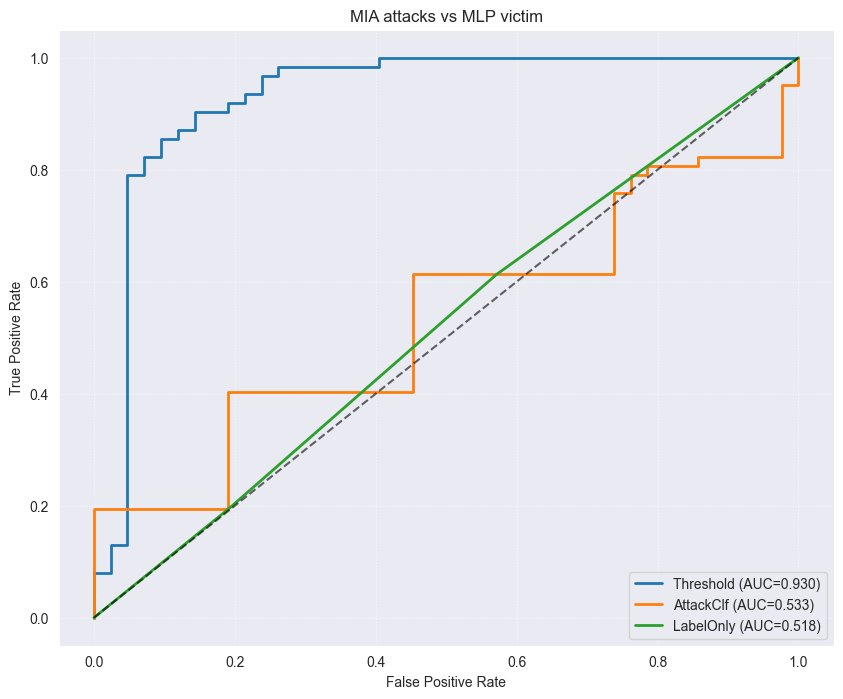

In [11]:
# Cell 11: summary & ROC plot
from sklearn.metrics import roc_curve

auc_thresh = roc_auc_score(y_eval_is_member, thresh_scores_mlp)
auc_att = roc_auc_score(y_eval_is_member, attack_scores_ml)
auc_label = roc_auc_score(y_eval_is_member, lbl_attack_scores)

print("Summary AUCs (MLP):")
print(f"  Threshold : {auc_thresh:.4f}")
print(f"  AttackClf : {auc_att:.4f}")
print(f"  LabelOnly : {auc_label:.4f}")

fpr_t, tpr_t, _ = roc_curve(y_eval_is_member, thresh_scores_mlp)
fpr_a, tpr_a, _ = roc_curve(y_eval_is_member, attack_scores_ml)
fpr_lo, tpr_lo, _ = roc_curve(y_eval_is_member, lbl_attack_scores)

plt.figure(figsize=(10,8))
plt.plot(fpr_t, tpr_t, label=f"Threshold (AUC={auc_thresh:.3f})", linewidth=2)
plt.plot(fpr_a, tpr_a, label=f"AttackClf (AUC={auc_att:.3f})", linewidth=2)
plt.plot(fpr_lo, tpr_lo, label=f"LabelOnly (AUC={auc_label:.3f})", linewidth=2)
plt.plot([0,1],[0,1],'k--', alpha=0.6)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("MIA attacks vs MLP victim")
plt.legend(loc="lower right")
plt.grid(ls=":", alpha=0.6)
plt.show()


In [12]:
# Cell 12: save scores for reporting
out_df = pd.DataFrame({
    "is_member": y_eval_is_member,
    "loss_eval": loss_eval_mlp,
    "thresh_score": thresh_scores_mlp,
    "attack_score": attack_scores_ml,
    "labelonly_score": lbl_attack_scores
})
out_df.to_csv("mlp_mia_scores.csv", index=False)
print("Saved mlp_mia_scores.csv")


Saved mlp_mia_scores.csv
